# Modellerin Performans Değerlendirilmesi

Bu notebook öncekine kıyasla sadece kaydedilmiş verisetini drive üzerinden okuyarak alır ve modelleri kullanarak test eder.

Bu çalışmada kullanılan modeller şunlardır:

1. AutoEncoder
2. PatchCore


Ek olarak şunlar de denenmeye çalışılacak:


In [ ]:
pip install -U anomalib timm lightning


# Dataset

In [73]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from pathlib import Path
from tqdm.notebook import tqdm
import shutil
from skimage import exposure
import json

# Deep Learning Kütüphaneleri
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets


from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    roc_curve,
    roc_auc_score,
    auc
)

# tqdm'un pandas ile entegrasyonu için
tqdm.pandas()

In [ ]:
# Çalıştığın ortama göre
ENVIRONMENT = "local" # "local"

In [75]:
if ENVIRONMENT == "colab":
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_PATH = "/content/drive/MyDrive/Kod/machine_learning/"
    PROJECT_ROOT = os.path.join(DRIVE_PATH, "Kod")
    DATASET_ROOT = os.path.join(DRIVE_PATH, "dataset")
else:
    # PROJECT_ROOT = os.path.join(os.path.dirname(os.path.abspath(__file__)), "..")
    PROJECT_ROOT = os.getcwd()
    DATASET_ROOT = os.path.join(PROJECT_ROOT, "dataset")

# Orijinal olan veriler
ORIGINAL_DATA = os.path.join(DATASET_ROOT, "wood")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
SELECTED_DATASET = os.path.join(DATASET_ROOT, "wood_otsu_clahe")
TRAIN_GOOD_PATH = os.path.join(SELECTED_DATASET, "train", "good")
TEST_GOOD_PATH = os.path.join(SELECTED_DATASET, "test", "good")
TEST_DEFECT_PATH = os.path.join(SELECTED_DATASET, "test", "defect")

print(f"Orijinal Dataset Path: {SELECTED_DATASET}")
print(f"Kullanılacak Dataset Path: {SELECTED_DATASET}")

Orijinal Dataset Path: /content/drive/MyDrive/Kod/machine_learning/dataset/wood_otsu_clahe
Kullanılacak Dataset Path: /content/drive/MyDrive/Kod/machine_learning/dataset/wood_otsu_clahe


Klasörler içerisindeki resim sayıları

In [77]:
import os

def count_files(path, exts={".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}):
    if not os.path.exists(path):
        return 0
    return sum(
        1 for f in os.listdir(path)
        if os.path.isfile(os.path.join(path, f)) and Path(f).suffix.lower() in exts
    )


print(f"Kullanılacak Dataset Path: {SELECTED_DATASET}\n")

print("📁 Veri Sayıları")
print(f"TRAIN / good      : {count_files(TRAIN_GOOD_PATH)}")
print(f"TEST  / good      : {count_files(TEST_GOOD_PATH)}")
print(f"TEST  / defect    : {count_files(TEST_DEFECT_PATH)}")


Kullanılacak Dataset Path: /content/drive/MyDrive/Kod/machine_learning/dataset/wood_otsu_clahe

📁 Veri Sayıları
TRAIN / good      : 90
TEST  / good      : 10
TEST  / defect    : 36


In [78]:
IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

def imread_unicode(path, flags=cv2.IMREAD_GRAYSCALE):
    data = np.fromfile(path, dtype=np.uint8)
    img = cv2.imdecode(data, flags)
    return img


In [79]:
def check_image_shapes(path, max_check=20):
    shapes = set()
    files = list(Path(path).iterdir())[:max_check]

    for p in files:
        img = imread_unicode(str(p))
        if img is not None:
            shapes.add(img.shape)

    return shapes



print("Train shapes:", check_image_shapes(TRAIN_GOOD_PATH))
print("Test good shapes:", check_image_shapes(TEST_GOOD_PATH))
print("Test defect shapes:", check_image_shapes(TEST_DEFECT_PATH))


Train shapes: {(256, 256)}
Test good shapes: {(256, 256)}
Test defect shapes: {(256, 256)}


In [80]:
def show_samples(path, n=6, title=""):
    files = [
        p for p in Path(path).iterdir()
        if p.is_file()
    ]

    if len(files) == 0:
        print(f"Görüntü yok: {path}")
        return

    files = random.sample(files, min(n, len(files)))

    plt.figure(figsize=(12, 6))
    idx = 1
    for f in files:
        img = imread_unicode(str(f))
        if img is None:
            continue
        plt.subplot(2, 3, idx)
        plt.imshow(img, cmap="gray")
        plt.title(f.name[:20])
        plt.axis("off")
        idx += 1

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# show_samples(TRAIN_GOOD_PATH, title="Train Good")
# show_samples(TEST_DEFECT_PATH, title="Test Defect")


### Util func.

In [81]:


def normalize_image(image):
    """
    Görüntüyü 0-1 aralığına normalize eder

    Args:
        image: Numpy array (0-255)

    Returns:
        Normalize edilmiş görüntü (0-1)
    """
    return image.astype(np.float32) / 255.0


def calculate_metrics(y_true, y_scores, threshold=0.5):
    """
    Sınıflandırma metriklerini hesaplar

    Args:
        y_true: Gerçek etiketler (0: normal, 1: anomaly)
        y_scores: Anomali skorları (0-1 arası)
        threshold: Karar eşiği

    Returns:
        Metrik sözlüğü
    """
    # Binary predictions
    y_pred = (y_scores >= threshold).astype(int)

    # Metrikler
    results = {
        'auc_score': roc_auc_score(y_true, y_scores),
        'f1_score': f1_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'accuracy': accuracy_score(y_true, y_pred),
        'confusion_matrix': confusion_matrix(y_true, y_pred).tolist(),
        'threshold': threshold,
        'y_scores': y_scores.tolist() if isinstance(y_scores, np.ndarray) else y_scores,
        'y_true': y_true.tolist() if isinstance(y_true, np.ndarray) else y_true
    }

    return results


def plot_metrics(y_true, y_scores, y_pred, model_name="Model"):
    """
    Metrik sonuçlarını görselleştirir

    Args:
        results: calculate_metrics fonksiyonundan dönen sözlük
        model_name: Model adı
    """

    # Metrikler
    auc = roc_auc_score(y_true, y_scores)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)

    # Figure
    fig, ax = plt.subplots(figsize=(5, 6))

    # Confusion matrix çizimi
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(f"Confusion Matrix - {model_name}", fontsize=12)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Good (0)", "Defect (1)"])
    ax.set_yticklabels(["Good (0)", "Defect (1)"])

    # Hücre içi sayılar
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    fontsize=12, fontweight="bold")

    # Alt kısma metrikleri yaz
    metrics_text = (
        f"AUC: {auc:.4f}    "
        f"F1: {f1:.4f}    "
        f"Accuracy: {acc:.4f}\n"
        f"Precision: {prec:.4f}    "
        f"Recall: {rec:.4f}"
    )

    plt.figtext(
        0.5, -0.05, metrics_text,
        ha="center",
        fontsize=10,
        bbox=dict(facecolor="white", edgecolor="gray", boxstyle="round,pad=0.4")
    )

    plt.tight_layout()
    plt.show()

def save_model_results(model_name, results, output_dir="results"):
    """
    Model sonuçlarını dosyaya kaydeder

    Args:
        model_name: Model adı
        results: Metrik sonuçları
        output_dir: Çıktı dizini
    """
    os.makedirs(output_dir, exist_ok=True)

    # JSON olarak kaydet
    output_file = os.path.join(output_dir, f"{model_name}_results.json")

    # Numpy array'leri liste'ye çevir
    results_copy = results.copy()

    with open(output_file, 'w') as f:
        json.dump(results_copy, f, indent=4)

    print(f"\n✅ Sonuçlar kaydedildi: {output_file}")


def compare_models(results_list, model_names):
    """
    Birden fazla modelin performansını karşılaştırır

    Args:
        results_list: Model sonuçları listesi
        model_names: Model isimleri listesi
    """
    metrics_to_compare = ['auc_score', 'f1_score', 'precision', 'recall', 'accuracy']

    # DataFrame oluştur
    comparison_data = []
    for model_name, results in zip(model_names, results_list):
        row = {'Model': model_name}
        for metric in metrics_to_compare:
            row[metric] = results.get(metric, 0)
        comparison_data.append(row)

    df = pd.DataFrame(comparison_data)

    # Görselleştirme
    fig, axes = plt.subplots(1, len(metrics_to_compare), figsize=(18, 4))

    for idx, metric in enumerate(metrics_to_compare):
        axes[idx].bar(df['Model'], df[metric])
        axes[idx].set_title(metric.replace('_', ' ').title())
        axes[idx].set_ylim(0, 1)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Tablo yazdır
    print("\n=== MODEL KARŞILAŞTIRMA TABLOSU ===")
    print(df.to_string(index=False))
    print("="*60)

    return df


def visualize_anomaly_heatmap(
    model,
    dataset,
    index,
    device,
    threshold=None
):
    model.eval()

    # 1) Görüntüyü al
    sample = dataset[index]
    if isinstance(sample, tuple):
        image = sample[0]
        label = sample[1]
    else:
        image = sample
        label = None

    image = image.unsqueeze(0).to(device)  # [1,1,H,W]

    # 2) Reconstruction
    with torch.no_grad():
        recon = model(image)

    # 3) Error map (pixel-wise)
    error_map = torch.abs(recon - image)
    error_map = error_map.squeeze().cpu().numpy()

    # Normalize (0–1)
    error_map = (error_map - error_map.min()) / (error_map.max() - error_map.min() + 1e-8)

    # Orijinal görüntü
    original = image.squeeze().cpu().numpy()

    # 4) Heatmap üret
    heatmap = cv2.applyColorMap(
        np.uint8(255 * error_map),
        cv2.COLORMAP_JET
    )
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Orijinali RGB yap
    original_rgb = np.stack([original]*3, axis=-1)
    original_rgb = np.uint8(255 * original_rgb)

    # 5) Overlay
    overlay = cv2.addWeighted(original_rgb, 0.6, heatmap, 0.4, 0)

    # 6) Plot
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    axes[0].imshow(original, cmap="gray")
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(recon.squeeze().cpu().numpy(), cmap="gray")
    axes[1].set_title("Reconstructed")
    axes[1].axis("off")

    axes[2].imshow(error_map, cmap="hot")
    axes[2].set_title("Anomaly Map")
    axes[2].axis("off")

    axes[3].imshow(overlay)
    title = "Overlay"
    if label is not None:
        title += f" | GT: {'Defect' if label==1 else 'Good'}"
    axes[3].set_title(title)
    axes[3].axis("off")

    plt.tight_layout()
    plt.show()


In [82]:
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import Dataset

IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".webp"}

def list_images(folder):
    folder = Path(folder)
    return sorted([
        p for p in folder.iterdir()
        if p.is_file() and p.suffix.lower() in IMG_EXTS
    ])

class WoodDataset(Dataset):
    def __init__(self, paths, labels=None):
        self.paths = list(paths)
        self.labels = None if labels is None else np.array(labels, dtype=np.int64)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = str(self.paths[idx])

        img = imread_unicode(path)  # senin Unicode-safe fonksiyonun
        if img is None:
            raise RuntimeError(f"Image could not be read: {path}")

        img = img.astype(np.float32) / 255.0   # [0,1]
        x = torch.from_numpy(img).unsqueeze(0) # [1,H,W]

        if self.labels is None:
            return x
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y


In [83]:
from torch.utils.data import DataLoader

train_paths = list_images(TRAIN_GOOD_PATH)

train_dataset = WoodDataset(train_paths)  # labels yok
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

print("Training set:", len(train_dataset))


Training set: 90


In [84]:
test_good_paths = list_images(TEST_GOOD_PATH)
test_defect_paths = list_images(TEST_DEFECT_PATH)

test_paths = test_good_paths + test_defect_paths
test_labels = np.array([0]*len(test_good_paths) + [1]*len(test_defect_paths))

test_dataset = WoodDataset(test_paths, test_labels)
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

print("Test set:", len(test_dataset))
print("Normal samples:", int((test_labels == 0).sum()))
print("Anomaly samples:", int((test_labels == 1).sum()))


Test set: 46
Normal samples: 10
Anomaly samples: 36


In [85]:
xb = next(iter(train_loader))
print("Train batch shape:", xb.shape)  # beklenen: [B, 1, 256, 256]

xb, yb = next(iter(test_loader))
print("Test batch shape:", xb.shape, "labels:", yb[:10].tolist())


Train batch shape: torch.Size([16, 1, 256, 256])
Test batch shape: torch.Size([16, 1, 256, 256]) labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# Modeller

## 1. AutoEncoder Modeli

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, in_channels=1, latent_dim=128):
        super(AutoEncoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=4, stride=2, padding=1), # Output: 32x128x128
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # Output: 64x64x64
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # Output: 128x32x32
            nn.ReLU(True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # Output: 256x16x16
            nn.ReLU(True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, latent_dim, kernel_size=4, stride=2, padding=1), # Output: latent_dim x 8 x 8
            nn.ReLU(True),
            nn.BatchNorm2d(latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=4, stride=2, padding=1), # Output: 256x16x16
            nn.ReLU(True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # Output: 128x32x32
            nn.ReLU(True),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # Output: 64x64x64
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # Output: 32x128x128
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, in_channels, kernel_size=4, stride=2, padding=1), # Output: in_channelsx256x256
            nn.Sigmoid() # Output pixels in [0, 1] range for image reconstruction
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

print("AutoEncoder model defined.")

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# model = ConvAutoEncoder().to(device)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-3)

model = AutoEncoder(in_channels=1, latent_dim=128).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Device: cuda


### train

In [ ]:
EPOCHS = 50
train_losses = []

model.train()

for epoch in range(EPOCHS):
    epoch_loss = 0.0

    for imgs in train_loader:
        imgs = imgs.to(device)

        optimizer.zero_grad()
        recon = model(imgs)
        loss = criterion(recon, imgs)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)

    print(f"Epoch [{epoch+1:02d}/{EPOCHS}] - Loss: {epoch_loss:.6f}")


Epoch [01/50] - Loss: 0.071855
Epoch [02/50] - Loss: 0.040670
Epoch [03/50] - Loss: 0.033323
Epoch [04/50] - Loss: 0.027968
Epoch [05/50] - Loss: 0.027265
Epoch [06/50] - Loss: 0.023799
Epoch [07/50] - Loss: 0.022323
Epoch [08/50] - Loss: 0.025880
Epoch [09/50] - Loss: 0.025541
Epoch [10/50] - Loss: 0.023127
Epoch [11/50] - Loss: 0.020146
Epoch [12/50] - Loss: 0.018417
Epoch [13/50] - Loss: 0.019305
Epoch [14/50] - Loss: 0.019571
Epoch [15/50] - Loss: 0.017263
Epoch [16/50] - Loss: 0.017883
Epoch [17/50] - Loss: 0.016747
Epoch [18/50] - Loss: 0.015985
Epoch [19/50] - Loss: 0.016077
Epoch [20/50] - Loss: 0.015614
Epoch [21/50] - Loss: 0.014767
Epoch [22/50] - Loss: 0.014791
Epoch [23/50] - Loss: 0.016116
Epoch [24/50] - Loss: 0.015401
Epoch [25/50] - Loss: 0.015425
Epoch [26/50] - Loss: 0.014985
Epoch [27/50] - Loss: 0.014845
Epoch [28/50] - Loss: 0.015014
Epoch [29/50] - Loss: 0.015185
Epoch [30/50] - Loss: 0.013805
Epoch [31/50] - Loss: 0.013970
Epoch [32/50] - Loss: 0.014320
Epoch [3

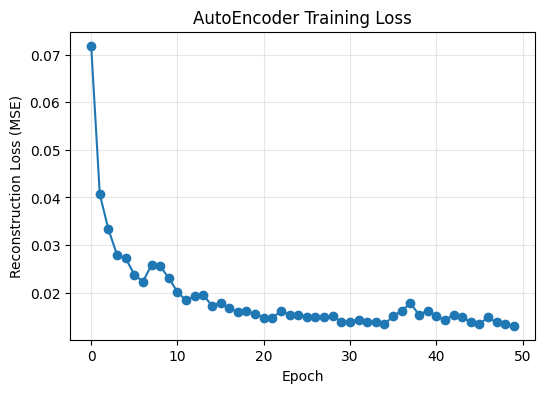

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(train_losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss (MSE)")
plt.title("AutoEncoder Training Loss")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
model.eval()
train_scores = []

with torch.no_grad():
    for imgs in train_loader:
        imgs = imgs.to(device)
        recon = model(imgs)

        # per-image reconstruction error
        error = torch.mean((recon - imgs) ** 2, dim=(1,2,3))
        train_scores.extend(error.cpu().numpy())

train_scores = np.array(train_scores)

print(
    "Train scores:",
    f"min={train_scores.min():.6f},",
    f"mean={train_scores.mean():.6f},",
    f"max={train_scores.max():.6f}"
)


Train scores: min=0.010272, mean=0.012911, max=0.025310


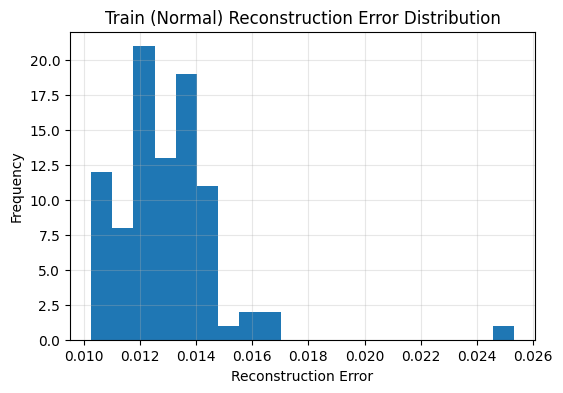

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(train_scores, bins=20)
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Train (Normal) Reconstruction Error Distribution")
plt.grid(alpha=0.3)
plt.show()


### Test

In [ ]:
import numpy as np
import torch

model.eval()

y_true = []
y_scores = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        recon = model(xb)

        # per-image reconstruction error (MSE)
        err = torch.mean((recon - xb) ** 2, dim=(1,2,3))

        y_scores.extend(err.detach().cpu().numpy())
        y_true.extend(yb.numpy())

y_true = np.array(y_true).astype(int)
y_scores = np.array(y_scores).astype(float)

print("Test scores:",
      f"min={y_scores.min():.6f}, mean={y_scores.mean():.6f}, max={y_scores.max():.6f}")
print("y_true counts:", {0: int((y_true==0).sum()), 1: int((y_true==1).sum())})


Test scores: min=0.010436, mean=0.013340, max=0.027256
y_true counts: {0: 10, 1: 36}


In [ ]:
from sklearn.metrics import roc_curve
import numpy as np

# ROC üzerinden threshold hesapla
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
best_idx = np.argmax(tpr - fpr)   # Youden J
best_threshold = thresholds[best_idx]

print("Kullanılan threshold:", best_threshold)

# y_pred oluştur
y_pred = (y_scores >= best_threshold).astype(int)

print("y_pred (ilk 20):", y_pred[:20])
print("y_true (ilk 20):", y_true[:20])


Kullanılan threshold: 0.01123239565640688
y_pred (ilk 20): [0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
y_true (ilk 20): [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


In [ ]:
j = tpr - fpr
best_idx = np.argmax(j)
best_thr = thresholds[best_idx]
print("Best threshold (Youden J):", float(best_thr))


Best threshold (Youden J): 0.01123239565640688


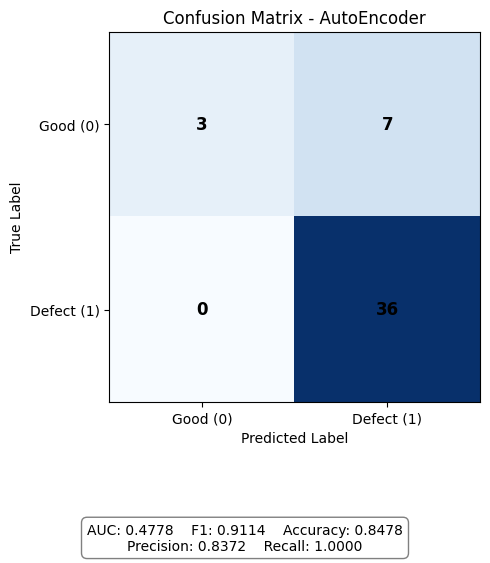

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plot_metrics(y_true=y_true, y_scores=y_scores, y_pred=y_pred, model_name="AutoEncoder" )


In [ ]:
# Test dataset label’ları varsa
defect_indices = np.where(np.array(test_dataset.labels) == 1)[0]
good_indices   = np.where(np.array(test_dataset.labels) == 0)[0]

print("Defect örnek sayısı:", len(defect_indices))


Defect örnek sayısı: 36


### Defect Örnekler için Isı haritası




In [ ]:
for idx in defect_indices[:3]:
    visualize_anomaly_heatmap(
        model=model,
        dataset=test_dataset,
        index=idx,
        device=device
    )


Output hidden; open in https://colab.research.google.com to view.

### Good Örnekler için Isı haritası



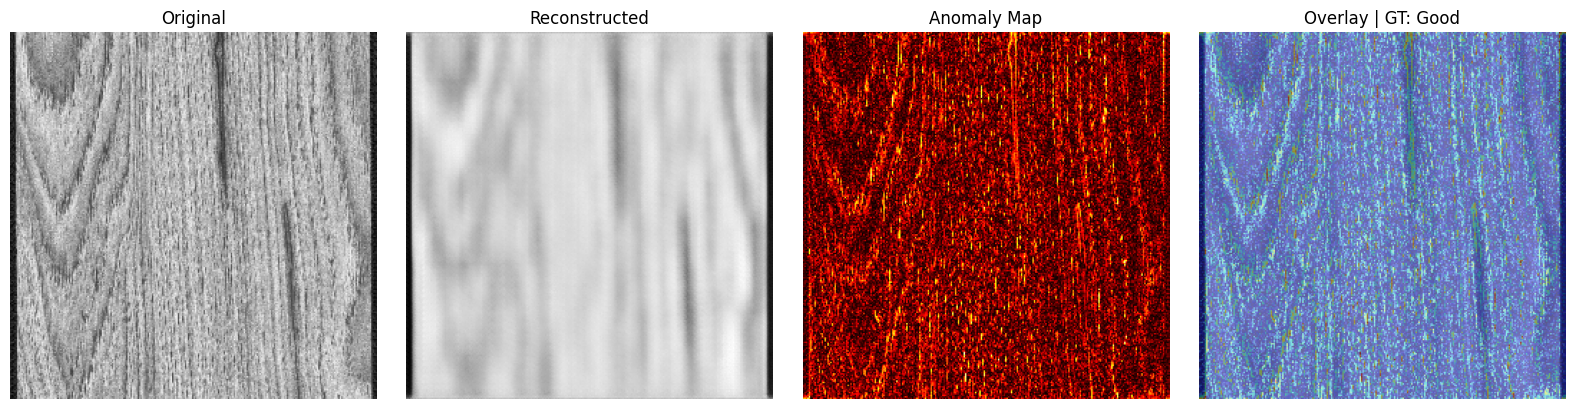

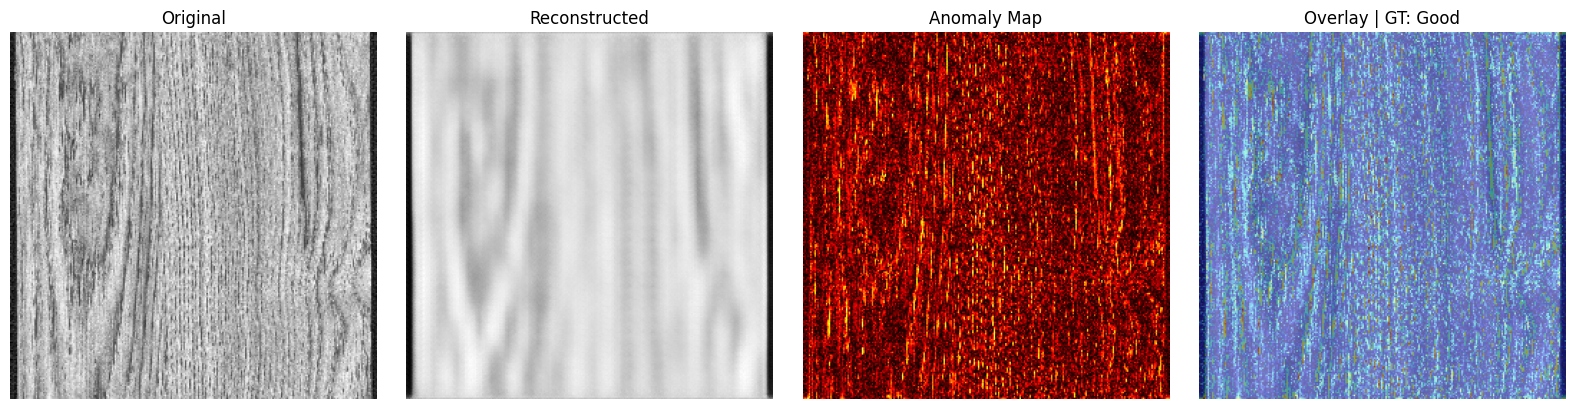

In [ ]:
for idx in good_indices[:2]:
    visualize_anomaly_heatmap(
        model=model,
        dataset=test_dataset,
        index=idx,
        device=device
    )


## 2. PatchCore Modeli

In [86]:
from anomalib.models import Patchcore
from anomalib.engine import Engine
from anomalib.data import Folder


In [87]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # PatchCore RGB ister
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

In [88]:
SELECTED_DATASET

'/content/drive/MyDrive/Kod/machine_learning/dataset/wood_otsu_clahe'

In [89]:
datamodule = Folder(
    name="wood",
    root=SELECTED_DATASET,
    normal_dir="train/good",
    abnormal_dir="test/defect",
    normal_test_dir="test/good",
    val_split_ratio=0.0 # Varsayılan %50 split'i kapat, tüm veriyi test için kullan
)
datamodule.setup()

In [90]:
model = Patchcore(
    backbone="wide_resnet50_2",
    layers=["layer2", "layer3"],
    coreset_sampling_ratio=0.1
)

In [91]:
from lightning.pytorch.callbacks import TQDMProgressBar

# Train using the Engine
# Colab ortamında Rich kütüphanesi ile ilgili RecursionError hatasını önlemek için
# varsayılan RichProgressBar yerine TQDMProgressBar kullanıyoruz.
engine = Engine(
    callbacks=[TQDMProgressBar(refresh_rate=20)],
)
engine.fit(model=model, datamodule=datamodule)

INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type           ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ pre_processor  │ PreProcessor   │      0 │ train │     0 │
│ 1 │ post_processor │ PostProcessor  │      0 │ train │     0 │
│ 2 │ evaluator      │ Evaluator      │      0 │ train │     0 │
│ 3 │ model          │ PatchcoreModel │ 24.9 M │ train │     0 │
└───┴────────────────┴────────────────┴────────┴───────┴───────┘

Trainable params: 24.9 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 24.9 M                                                                                               
Total estimated model params size (MB): 99                                                                         
Modules in train mode: 19                                                                                          
Modules in eval mode: 174                                                                                          
Total FLOPs: 0

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:534: Found 174 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]



Selecting Coreset Indices.:   0%|          | 0/9216 [00:00<?, ?it/s]

Selecting Coreset Indices.:   1%|          | 60/9216 [00:00<00:15, 592.30it/s]

Selecting Coreset Indices.:   1%|▏         | 125/9216 [00:00<00:14, 622.83it/s]

Selecting Coreset Indices.:   2%|▏         | 190/9216 [00:00<00:14, 632.95it/s]

Selecting Coreset Indices.:   3%|▎         | 256/9216 [00:00<00:13, 641.42it/s]

Selecting Coreset Indices.:   3%|▎         | 321/9216 [00:00<00:13, 641.84it/s]

Selecting Coreset Indices.:   4%|▍         | 386/9216 [00:00<00:13, 644.57it/s]

Selecting Coreset Indices.:   5%|▍         | 451/9216 [00:00<00:13, 643.48it/s]

Selecting Coreset Indices.:   6%|▌         | 516/9216 [00:00<00:13, 645.35it/s]

Selecting Coreset Indices.:   6%|▋         | 581/9216 [00:00<00:13, 638.32it/s]

Selecting Coreset Indices.:   7%|▋         | 646/9216 [00:01<00:13, 639.13it/s]

Selecting Coreset Indices.:   8%|▊         | 711/9216 [00:01<00:13, 640.65it/s]

Selecting Coreset Indices.:   8%|▊    

In [96]:
from anomalib.data import Folder
from anomalib.models import Patchcore
from anomalib.engine import Engine
from lightning.pytorch.callbacks import TQDMProgressBar
import torch

# 1. Veri Modülünü Hazırla
# val_split_ratio=0.0 diyerek tüm 'test' klasöründeki verileri test için saklıyoruz.
datamodule = Folder(
    name="wood",
    root=SELECTED_DATASET,
    normal_dir="train/good",
    abnormal_dir="test/defect",
    normal_test_dir="test/good",
    val_split_mode="from_test",
    val_split_ratio=0.0,
    seed=42,
    image_size=(256, 256) # Modelin beklediği görüntü boyutu
)
datamodule.setup()

TypeError: Folder.__init__() got an unexpected keyword argument 'image_size'

In [97]:
# 2. Model ve Eğitim (Engine)
model = Patchcore(
    backbone="wide_resnet50_2",
    layers=["layer2", "layer3"],
    coreset_sampling_ratio=0.1
)

# RecursionError önlemi ile Engine tanımla
engine = Engine(
    callbacks=[TQDMProgressBar(refresh_rate=20)],
    max_epochs=1, # PatchCore için 1 epoch yeterli (bellek bankası oluşturuluyor)
    pixel_metrics=["AUROC"],
    image_metrics=["AUROC", "F1Score", "Accuracy", "Precision", "Recall"]
)

print("--- Model Eğitimi Başlıyor ---")
engine.fit(model=model, datamodule=datamodule)

--- Model Eğitimi Başlıyor ---


AttributeError: 'ManualDataModule' object has no attribute 'name'

In [98]:
# 3. Test Sonuçları (Anomalib Metrikleri)
print("--- Test İşlemi Başlıyor ---")
# engine.test otomatik olarak datamodule.test_dataloader() kullanır
test_results = engine.test(model=model, datamodule=datamodule)

# Sonuçları yazdır
print(test_results)

--- Test İşlemi Başlıyor ---


AttributeError: 'ManualDataModule' object has no attribute 'name'

In [99]:
# 4. Tahminleri Al ve Confusion Matrix Çiz (Manuel Çizim)
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

predictions = engine.predict(model=model, datamodule=datamodule)

pred_labels = []
gt_labels = []
pred_scores = []

# Anomalib prediction çıktılarını ayrıştır
for pred in predictions:
    # pred bir batch sözlüğü veya nesnesidir
    # Genellikle 'pred_labels', 'gt_labels', 'pred_scores' içerir
    if "pred_labels" in pred:
        pred_labels.extend(pred["pred_labels"].cpu().numpy())
    if "gt_label" in pred: # Dikkat: gt_label (tekil) veya gt_labels (çoğul) olabilir versiyona göre
         gt_labels.extend(pred["gt_label"].cpu().numpy())
    if "pred_score" in pred:
        pred_scores.extend(pred["pred_score"].cpu().numpy())

# NumPy array'e çevir
pred_labels = np.array(pred_labels).astype(int)
gt_labels = np.array(gt_labels).astype(int)

# Confusion Matrix
cm = confusion_matrix(gt_labels, pred_labels)

# Görselleştirme fonksiyonumuz (plot_metrics içindeki mantık veya basit çizim)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Good (0)", "Defect (1)"],
            yticklabels=["Good (0)", "Defect (1)"])
plt.title("Confusion Matrix (PatchCore - Engine)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(f"Test Seti Boyutu: {len(gt_labels)}")

AttributeError: 'ManualDataModule' object has no attribute 'name'

In [92]:
# Get predictions
predictions = engine.predict(model=model, datamodule=datamodule)

INFO:lightning_fabric.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

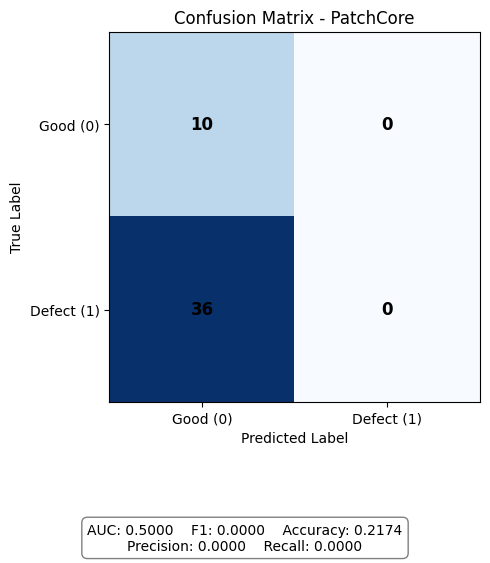

In [94]:
# 1. Confusion Matrix Görselleştirme
plot_metrics(y_true, y_scores, y_pred, model_name="PatchCore")

--- PatchCore Anomali Haritaları ---
Test Dataloader Örnek Sayısı: 46 (Dataset toplamından farklı olabilir)
Gösterilecek Defect Örnek Sayısı: 3


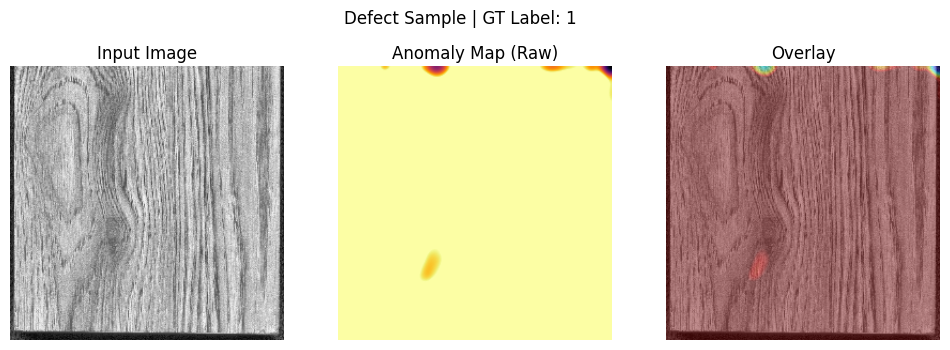

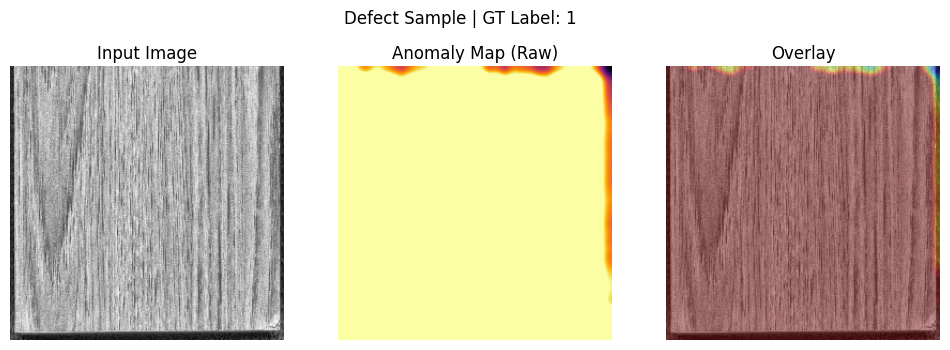

Exception ignored in: <function tqdm.__del__ at 0x7a27d96f37e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/usr/local/lib/python3.12/dist-packages/tqdm/std.py", line 1277, in close
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    if self.last_print_t < self.start_t + self.delay:
       ^^^^^^^^^^^^^^^^^
AttributeError: 'tqdm' object has no attribute 'last_print_t'
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 

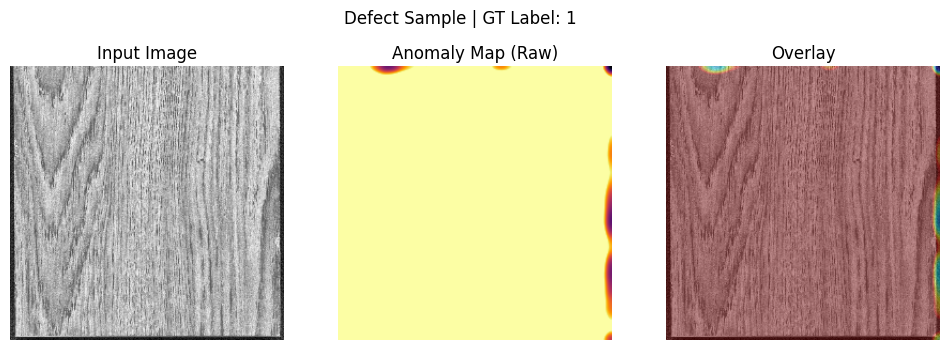

In [95]:
# 2. PatchCore Isı Haritaları (Heatmaps)
import cv2

def denormalize(tensor):
    """Normalize edilmiş tensörü orijinal görüntü aralığına (0-1) çeker"""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = tensor.permute(1, 2, 0).cpu().numpy()
    img = img * std + mean
    return np.clip(img, 0, 1)

def show_patchcore_heatmap(model, datamodule, count=3):
    # Dataloader'ı hazırla
    loader = datamodule.test_dataloader()
    total_samples = len(loader.dataset)

    print(f"--- PatchCore Anomali Haritaları ---")
    print(f"Test Dataloader Örnek Sayısı: {total_samples} (Dataset toplamından farklı olabilir)")
    print(f"Gösterilecek Defect Örnek Sayısı: {count}")

    model.eval()
    shown = 0

    for batch in loader:
        images = batch["image"].to(model.device)
        labels = batch["gt_label"].cpu().numpy()

        with torch.no_grad():
            output = model(images)

        # Anomaly map'i çıktıdan al
        if hasattr(output, "anomaly_map"):
            anomaly_maps = output.anomaly_map
        elif isinstance(output, tuple):
             # Bazı versiyonlarda (anomaly_map, score) dönebilir
            anomaly_maps = output[0]
        else:
            print("Anomaly map çıktıda bulunamadı.")
            return

        # Batch içindeki görselleri gez
        for i in range(len(images)):
            # Sadece defect (etiket 1) olanları gösterelim
            if labels[i] == 1:
                img_in = denormalize(images[i])
                amap = anomaly_maps[i].squeeze().cpu().numpy()

                # Görüntü boyutuna resize et (PatchCore bazen küçük map dönebilir)
                if amap.shape != img_in.shape[:2]:
                    amap = cv2.resize(amap, (img_in.shape[1], img_in.shape[0]))

                # Normalize amap (0-1 arası) görselleştirme için
                amap_norm = (amap - amap.min()) / (amap.max() - amap.min() + 1e-8)

                # Heatmap renk dönüşümü
                heatmap = cv2.applyColorMap(np.uint8(255 * amap_norm), cv2.COLORMAP_JET)
                heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

                # Orijinal resim ile birleştir (Overlay)
                overlay = cv2.addWeighted(np.uint8(255*img_in), 0.6, heatmap, 0.4, 0)

                # Çizdir
                fig, ax = plt.subplots(1, 3, figsize=(12, 4))
                ax[0].imshow(img_in)
                ax[0].set_title("Input Image")
                ax[0].axis("off")

                ax[1].imshow(amap, cmap="inferno")
                ax[1].set_title("Anomaly Map (Raw)")
                ax[1].axis("off")

                ax[2].imshow(overlay)
                ax[2].set_title("Overlay")
                ax[2].axis("off")

                plt.suptitle(f"Defect Sample | GT Label: {labels[i]}")
                plt.show()

                shown += 1
                if shown >= count:
                    return

# Fonksiyonu çalıştır (Güncellenmiş test seti ile)
show_patchcore_heatmap(model, datamodule, count=3)